#Aaron Ye's Final Code
Includes final code and any additional variations that were used or mentioned in the paper

In [32]:
#Additional packages must either be installed or modified otherwise specific
#components like GloVe embedding will not work
!pip install datasets
!pip install -U torchtext==0.17.0

Initial Imports

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
import collections
import datasets
import torchtext

import matplotlib.pyplot as plt

Hyperparameters

In [34]:
seed = 1234
testSize = 0.25
maxLength = 256
batchSize = 512
minFreq = 5
dropoutRate = 0.2
nEpochs = 20

In [35]:
#Code for seed that affects random word generation
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


#Importing train and testing data
trainData, testData = datasets.load_dataset("imdb", split=["train", "test"])
#Alternate code for financial dataset
#train_data, test_data = datasets.load_dataset("zeroshot/twitter-financial-news-sentiment", split=["train", "validation"])
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [36]:
#Better variation to one on one filtering, translates a string into mutiple tokens, seperates special characters too
def tokenizeSentences(sentences, tokenizer, maxLength):
    tokens = tokenizer(sentences["text"])[:maxLength]
    return {"tokens": tokens}


#Old filtering code, loops through sentence and replaces anything it sees before splitting
"""
def filterSentences(sentence):
    sentence = sentence.replace(".", " . ") \
                 .replace("it's", "it is") \
                 .replace("haven't", "have not") \
                 .replace("don't", "do not") \
                 .replace("didn't", "did not") \
                 .replace("you've", "you have") \
                 .replace("I'll", "I will") \
                 .replace("I'm", "I am") \
                 .replace("wouldn't", "would not") \
                 .replace("doesn't", "does not") \
                 .replace("there's", "there is") \
                 .replace("that's", "that is") \
                 .replace("can't", "can not") \
                 .replace("I've", "I have") \
                 .replace("he's", "he is") \
                 .replace("couldn't", "could not") \
                 .replace("shouldn't", "should not") \
                 .replace("wasn't", "was not") \
                 .replace("aren't", "are not") \
                 .replace("you'll", "you will") \
                 .replace("we're", "we are") \
                 .replace("I'd", "I had") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace(":", " : ") \
                 .replace("(", " ( ") \
                 .replace(")", " ) ") \
                 .replace("<br />", " ") \
                 .replace("'", " ' ") \
                 .replace("\"", " \" ") \
                 .replace("!", " ! ") \
                 .replace("?", " ? ")
    return sentence.split()
"""

'\ndef filterSentences(sentence):\n    sentence = sentence.replace(".", " . ")                  .replace("it\'s", "it is")                  .replace("haven\'t", "have not")                  .replace("don\'t", "do not")                  .replace("didn\'t", "did not")                  .replace("you\'ve", "you have")                  .replace("I\'ll", "I will")                  .replace("I\'m", "I am")                  .replace("wouldn\'t", "would not")                  .replace("doesn\'t", "does not")                  .replace("there\'s", "there is")                  .replace("that\'s", "that is")                  .replace("can\'t", "can not")                  .replace("I\'ve", "I have")                  .replace("he\'s", "he is")                  .replace("couldn\'t", "could not")                  .replace("shouldn\'t", "should not")                  .replace("wasn\'t", "was not")                  .replace("aren\'t", "are not")                  .replace("you\'ll", "you will")           

In [37]:
#Adds an additional section for the tokens

trainData = trainData.map(tokenizeSentences, fn_kwargs={"tokenizer": tokenizer, "maxLength": maxLength})
testData = testData.map(tokenizeSentences, fn_kwargs={"tokenizer": tokenizer, "maxLength": maxLength})

#Split 1/4 of dataset for validation
tempValidData = trainData.train_test_split(test_size=testSize)
trainData = tempValidData["train"]
validData = tempValidData["test"]

specialTokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    trainData["tokens"],
    min_freq=5,
    specials=specialTokens,
)
unkIndex = vocab["<unk>"]
padIndex = vocab["<pad>"]
vocab.set_default_index(unkIndex)

In [38]:
#Give every value a numeric inditifier
def numericalizeExample(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [39]:
trainData = trainData.map(numericalizeExample, fn_kwargs={"vocab": vocab})
validData = validData.map(numericalizeExample, fn_kwargs={"vocab": vocab})
testData = testData.map(numericalizeExample, fn_kwargs={"vocab": vocab})

trainData = trainData.with_format(type="torch", columns=["ids", "label"])
validData = validData.with_format(type="torch", columns=["ids", "label"])
testData = testData.with_format(type="torch", columns=["ids", "label"])

In [40]:
def getCollateFn(padIndex):
    def collateFn(batch):
        batchIds = [i["ids"] for i in batch]
        batchIds = nn.utils.rnn.pad_sequence(
            batchIds, padding_value=padIndex, batch_first=True
        )
        batchLabel = [i["label"] for i in batch]
        batchLabel = torch.stack(batchLabel)
        batch = {"ids": batchIds, "label": batchLabel}
        return batch

    return collateFn

def getDataLoader(dataset, batchSize, padIndex, shuffle=False):
    collateFn = getCollateFn(padIndex)
    dataLoader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batchSize,
        collate_fn=collateFn,
        shuffle=shuffle,
    )
    return dataLoader

In [41]:
trainDataLoader = getDataLoader(trainData, batchSize, padIndex, shuffle=True)
validDataLoader = getDataLoader(validData, batchSize, padIndex)
testDataLoader = getDataLoader(testData, batchSize, padIndex)

In [42]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        embedded = self.dropout(self.embedding(ids))
        embedded = embedded.permute(0, 2, 1)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [conv.max(dim=-1).values for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        prediction = self.fc(cat)
        return prediction

In [43]:
def initializeWeights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [44]:
vocabSize = len(vocab)
embeddingDim = 300
nFilters = 100
filterSizes = [3, 5, 7]
outputDim = len(trainData.unique("label"))

model = CNN(
    vocabSize,
    embeddingDim,
    nFilters,
    filterSizes,
    outputDim,
    dropoutRate,
    padIndex,
)

model.apply(initializeWeights)

CNN(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [45]:
#Code section for Glove Embedding
vectors = torchtext.vocab.GloVe()
pretrainedEmbedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrainedEmbedding

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

In [46]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [47]:
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(nEpochs):
    train_loss, train_acc = train(
        trainDataLoader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(validDataLoader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.78it/s]


epoch: 0
train_loss: 0.754, train_acc: 0.623
valid_loss: 0.442, valid_acc: 0.793


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 13.15it/s]


epoch: 1
train_loss: 0.444, train_acc: 0.796
valid_loss: 0.332, valid_acc: 0.858


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.72it/s]


epoch: 2
train_loss: 0.344, train_acc: 0.851
valid_loss: 0.307, valid_acc: 0.870


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 13.44it/s]


epoch: 3
train_loss: 0.285, train_acc: 0.882
valid_loss: 0.293, valid_acc: 0.877


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.67it/s]


epoch: 4
train_loss: 0.247, train_acc: 0.898
valid_loss: 0.285, valid_acc: 0.884


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.54it/s]


epoch: 5
train_loss: 0.202, train_acc: 0.921
valid_loss: 0.280, valid_acc: 0.889


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 13.04it/s]


epoch: 6
train_loss: 0.170, train_acc: 0.937
valid_loss: 0.287, valid_acc: 0.887


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.88it/s]


epoch: 7
train_loss: 0.137, train_acc: 0.951
valid_loss: 0.281, valid_acc: 0.892


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.06it/s]


epoch: 8
train_loss: 0.110, train_acc: 0.964
valid_loss: 0.280, valid_acc: 0.894


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.17it/s]


epoch: 9
train_loss: 0.090, train_acc: 0.974
valid_loss: 0.290, valid_acc: 0.892


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.26it/s]


epoch: 10
train_loss: 0.071, train_acc: 0.981
valid_loss: 0.293, valid_acc: 0.892


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.74it/s]


epoch: 11
train_loss: 0.056, train_acc: 0.987
valid_loss: 0.300, valid_acc: 0.892


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.11it/s]


epoch: 12
train_loss: 0.046, train_acc: 0.991
valid_loss: 0.308, valid_acc: 0.891


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.29it/s]


epoch: 13
train_loss: 0.035, train_acc: 0.993
valid_loss: 0.317, valid_acc: 0.890


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.92it/s]


epoch: 14
train_loss: 0.031, train_acc: 0.994
valid_loss: 0.326, valid_acc: 0.891


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.47it/s]


epoch: 15
train_loss: 0.024, train_acc: 0.996
valid_loss: 0.334, valid_acc: 0.893


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.82it/s]


epoch: 16
train_loss: 0.021, train_acc: 0.997
valid_loss: 0.340, valid_acc: 0.893


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.73it/s]


epoch: 17
train_loss: 0.018, train_acc: 0.998
valid_loss: 0.358, valid_acc: 0.890


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.06it/s]


epoch: 18
train_loss: 0.015, train_acc: 0.998
valid_loss: 0.365, valid_acc: 0.889


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 18.06it/s]

epoch: 19
train_loss: 0.012, train_acc: 0.999
valid_loss: 0.368, valid_acc: 0.893


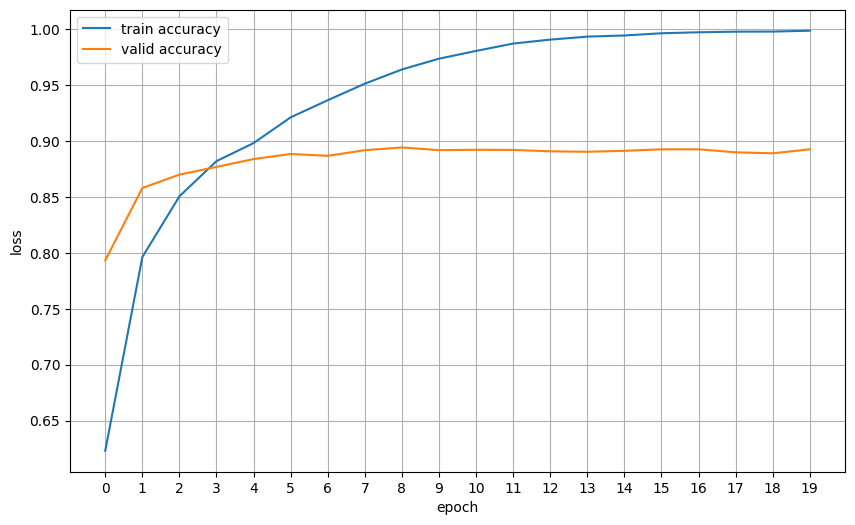

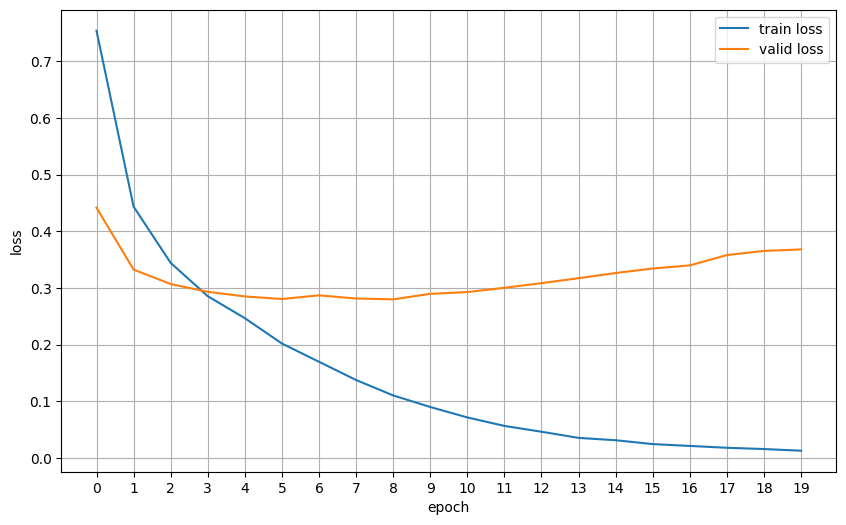

In [48]:
#Code for printing graphs for analysis

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(nEpochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(nEpochs))
ax.legend()
ax.grid()

In [49]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc = evaluate(testDataLoader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...: 100%|██████████| 49/49 [00:03<00:00, 14.22it/s]

test_loss: 0.301, test_acc: 0.879
